# Рабочий ноутбук для решения задачи предсказания территории на которой находится торговая точка

Данные поступают из двух файлов, которые формируются в существующей системой отчетности. В процессе обработки файлы могут быть объединены по полю “Код торговой точки”.
#### Файл Coordinates.xlsx
Файл содержит координаты торговых точек. Не все торговые точки имеют координаты. В процессе подготовки данных для обучения модели, точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат.
#### Файл Report Territory Management.xlsx
Данный файл является специальным отчетом, который требуется для работы оператора процесса, а также является входным файлом для последующего расчета. Файл содержит следующую информацию по точкам:
- Иерархия дистрибьюторов (Регион - Дистрибьютор - Филиал)
- Иерархия сотрудников
- Адресный классификатор (пять уровней)
- Характеристики точки: Сеть, Тир, Сегмент, Формат и т.п.
- Информация о посещении точки
- Код филиала на территории которого находится торговая точка (этот код необходимо предсказать, если отсутствует)

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import PatternFill

coord_file = 'Coordinates.xlsx'
report_file = 'Report Territory Management.xlsx'

## Анализ и подготовка данных

### Координаты точек

Посмотрим на файл с координатами точек. Видим, что в файле содержится 435 тысяч записей без пустых значений.

In [2]:
# Загрузка файла с кординатами в DataFrame
df_coor = pd.read_excel(coord_file)
df_coor.columns = ['SWE_Store_Key','Latitude','Longitude']
df_coor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435419 entries, 0 to 435418
Data columns (total 3 columns):
SWE_Store_Key    435419 non-null int64
Latitude         435419 non-null float64
Longitude        435419 non-null float64
dtypes: float64(2), int64(1)
memory usage: 10.0 MB


Но что с валидностью значений? Необходимо учитывать, что допустимые значения широты находятся в диапазоне от -90 до +90, а значения долготы - в диапазоне от -180 до +180. Откинем недопустимые значения. Как видим, их не много.

In [3]:
# Оставить только допустимые координаты (широта -90...+90, долгота -180..+180)
init_num = df_coor.shape[0]
df_coor = df_coor[(df_coor['Latitude']>=-90) & (df_coor['Latitude']<=90)]
df_coor = df_coor[(df_coor['Longitude']>=-180) & (df_coor['Longitude']<=180)]
print('Валидных значений: {0}, некорректных значений: {1}'.format(df_coor.shape[0], init_num - df_coor.shape[0]))

Валидных значений: 435411, некорректных значений: 8


Беря во внимание информацию из Википедии о крайних точках Российской Федерации (https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B0%D0%B9%D0%BD%D0%B8%D0%B5_%D1%82%D0%BE%D1%87%D0%BA%D0%B8_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), отбросим точки из других стран (берем с запасом). Осталось 396 тысяч точек с координатами

In [4]:
# Оставить только точки, с координатами в РФ
df_coor = df_coor[(df_coor['Latitude']>40)&(df_coor['Latitude']<82)]
df_coor = df_coor[((df_coor['Longitude']>=10)&(df_coor['Longitude']<180)) | \
    ((df_coor['Longitude']>=-180)&(df_coor['Longitude']<-160))]
print('Всего данных по точкам  в РФ: {0}'.format(df_coor.shape[0]))

Всего данных по точкам  в РФ: 396144


Посмотрим на распределение значений на графике типа Box & Whiskers. Получается медианное значение широты 55, а для долготы 50, с очевидно значительно меньшим количеством точек на крайних границах, которые не являются выбросами, в данном случае. Распределение не нормальное.

Text(0.5, 1.0, 'Долгота')

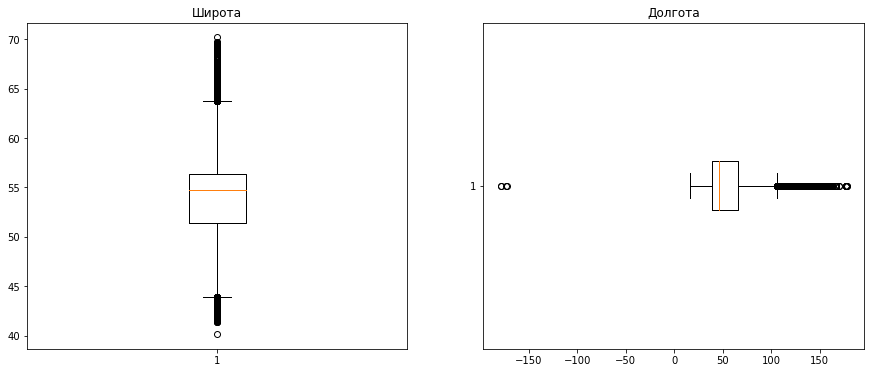

In [5]:
# Нарисовать графики типа Box & Whiskers
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].boxplot(df_coor['Latitude'].values)
axes[0].set_title('Широта')
axes[1].boxplot(df_coor['Longitude'].values, vert=False)
axes[1].set_title('Долгота')

Теперь перейдем к рассмотрению файла с основной информацией по торговым точкам. Как видно, информация по точке, полученная из справочников с основными мастер-данными, кажется полной (иерархия дистрибьюторов, иерархия сотрудников, информация по сети и точке, а также адресный классификатор), то есть признаки не содержат пропущенных значений.

In [6]:
# Загрузка файла с территориями точек в DataFrame и переименование столбцов для удобной работы
df_terr = pd.read_excel(report_file, skiprows=1)
df_terr.columns = ['Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1','Level_Torg_Region2',
    'Filial_Name','Filial_Ship_To','Chain_Type','Chain_Name','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','SWE_Store_Key','Store_Status','Outlet_Name','Channel_Name_2018',
    'Outlet_Type_2018','Trade_Structure','From_Dc','Segment_MWC_Segment_Name','Cluster_MWC',
    'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5','LSV_WWY','LSV_CHOCO',
    'LSV_MWC','Covering_Outlet_id','General_Duplicate','Ship_To_Visited','Filial_Visited',
    'Ship_to_Name_TO_BE','Region_loaded_RSS','Ship_to_TO_BE_Name_loaded_RSS','SHIP_TO_RSS',
    'Ship_to_Code_TO_BE','DC','Changed','Change_Period']

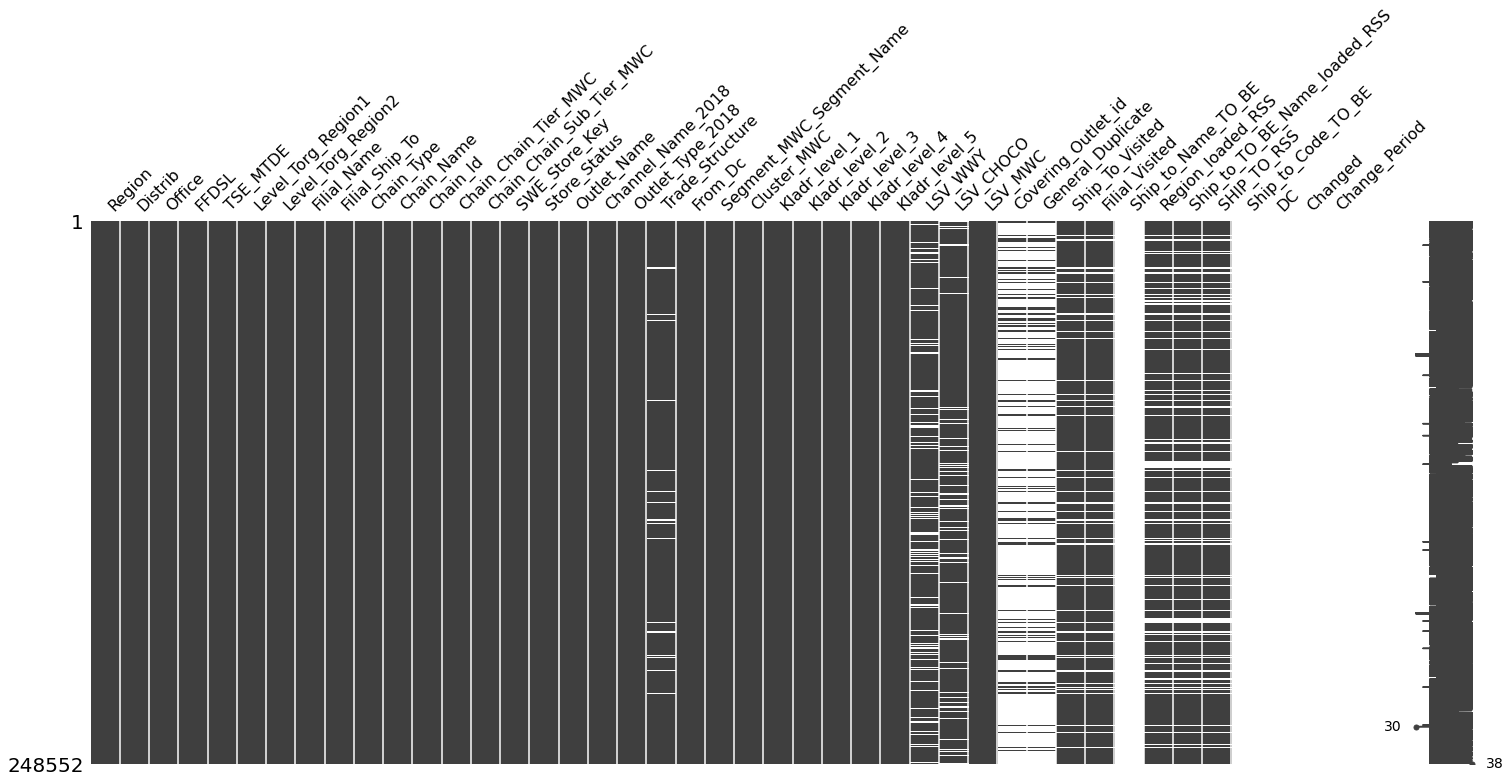

In [7]:
msno.matrix(df_terr)

Теперь удалим поля с названиями, для которых имеются соответствующие коды, а также поля без значений. Также нужно убрать информацию о продажах и визитах в точку (LSV, _Visited), так как это информация о последнем визите одного из дистрибьюторов в точку (а нам известно, что точку могут посещать несколько дистрибьюторов).

In [8]:
df_terr = df_terr[['SWE_Store_Key','Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1',
    'Level_Torg_Region2','Filial_Name','Filial_Ship_To','Chain_Type','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','Channel_Name_2018','Outlet_Type_2018','Trade_Structure','From_Dc',
    'Segment_MWC_Segment_Name','Cluster_MWC','Covering_Outlet_id','General_Duplicate','SHIP_TO_RSS',
    'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5']]

Также от бизнеса получена информация, что в данных содержится информация о точках-дубликатах и определен способ оставить только основные (актуальные) точки

In [9]:
df_terr = df_terr[df_terr['General_Duplicate']!='Дубликат']
df_terr.drop(['Covering_Outlet_id','General_Duplicate'], axis=1, inplace=True)

Посмотрим на признак SHIP_TO_RSS, смысл которого - это код адреса доставки (должен быть целым числом определенной длины). По условиям задачи необходимо предсказать значение SHIP_TO_RSS (это примерно 10% от общего числа точек в отчете).

In [10]:
# В отдельном DataFrame подсчитать длину поля SHIP_TO_RSS,
# а затем сгруппировать по длине и вывести первое значение из каждой группы
ship = df_terr[['SHIP_TO_RSS']]
ship.loc[~ship['SHIP_TO_RSS'].isna(),'LENGTH'] = \
    ship.loc[~ship['SHIP_TO_RSS'].isna()].SHIP_TO_RSS.apply(lambda x: len(str(x).strip()))
ship.groupby('LENGTH').SHIP_TO_RSS.first()

C:\Programs\anaconda3\envs\Territory_App\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Programs\anaconda3\envs\Territory_App\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


LENGTH
8.0                            10340352
19.0                10342443 , 10430024
30.0     10262975 , 10428588 , 10432783
Name: SHIP_TO_RSS, dtype: object

Задан дополнительный вопрос к бизнесу, почему для некоторых точек идёт два или три кода доставки, и получен ответ, что нужно использовать только первый код.

In [11]:
# SHIP_TO_RSS взять первые 8 символов и преобразовать к типу int
df_terr.loc[~df_terr['SHIP_TO_RSS'].isna(),'SHIP_TO_RSS'] = \
    df_terr.loc[~df_terr['SHIP_TO_RSS'].isna()]['SHIP_TO_RSS'].apply(lambda x: int(x[:9]))

Объединим отчет по территориям с координатами.

In [12]:
df = pd.merge(df_terr, df_coor, on='SWE_Store_Key', how='left')
del df_terr
del df_coor

Поскольку для каждой точки известен адрес, можно воспользоваться этой информацией, чтобы приблизительно восстановить координаты для точек с отсутствующими координатами. Для этого с бизнесом согласован алгоритм, при котором точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат. В случае отсутствия соседей в населенном пункте будет использоваться более высокий уровень адресного классификатора. После этого можно избавиться от адресного классификатора.

In [13]:
%%time
df['Latitude'].replace(0, np.NaN, inplace=True)
df['Longitude'].replace(0, np.NaN, inplace=True)
df['isCoord'] = ~( (df['Latitude'].isna()) | (df['Longitude'].isna()) )

kladr_lat_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Latitude.mean()
kladr_lon_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Longitude.mean()

def get_avg_coordinate(row, kladr_grouped):
    """
    Вернуть среднюю координату населенного пункта, области, региона или страны. Используем функции
    multiindex.isin().any(), чтобы проверить, что в Series имеется индекс для всех 4-х уровней
    и вернуть значение. В случае отсутствия индекса, отрубить последний уровень в индексе и проверить
    индекс для 3-х уровней и т.д.

    Parameters:
    row (Series): ['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'] для которых нужно
        получить координату
    kladr_grouped (Series): с мультииндексом ['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'])
        который содержит значения координаты для 4-х уровней из адресного классификатора
        
    Returns:
    float: Координата

    """
    try:
        if kladr_grouped.index \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4']]
        elif kladr_grouped.index.droplevel(['Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_2','Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'])]).any():
            return kladr_grouped[row['Kladr_level_1']].mean()
        else:
            return 0
    except:
        print(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])
        raise KeyError

df.loc[df['isCoord']==0,'Latitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lat_grouped,), axis=1)

df.loc[df['isCoord']==0,'Longitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lon_grouped,), axis=1)

Wall time: 3min 54s


In [14]:
df.drop(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5'], axis=1, inplace=True)

# Эксперименты

In [15]:
df_init = df.copy()

Почти подошли к построению модели. Поскольку искомый признак SHIP_TO_RSS это не непрерывная величина, а возможные фиксированные значения, то наша задача сводится к задаче мультиклассовой классификации. То есть необходимо обучить модель показывать наиболее вероятный код SHIP_TO_RSS по известным признакам.

Что здесь может пойти не так? Например, если в данных не будет хватать данных для успешного обучения по какому-то SHIP_TO_RSS. Давайте поищем такие случаи, при которых количество кодов для обучения меньше 25. Мы будем сообщать пользователю, о такой проблеме, а не будем пытаться угадать. Таких кодов всего 11.

In [16]:
ship_counts = df[~df['SHIP_TO_RSS'].isna()].groupby('SHIP_TO_RSS').SWE_Store_Key.count().to_frame()
ship_counts.reset_index(inplace=True)
ship_counts.columns = ['SHIP_TO_RSS','COUNTS']
ship_counts['SHIP_TO_RSS'] = ship_counts['SHIP_TO_RSS'].astype(int)
ship_counts[ship_counts['COUNTS']<25]

,SHIP_TO_RSS,COUNTS
66,10441510,9
67,10441560,7
69,10441605,3
70,10442916,2
71,10443010,1
72,10443011,21
73,10443031,19
74,10443103,7
75,10443104,13
77,10445233,5


В целом выборка данных не является сбалансированной, на что нужно обратить внимание.

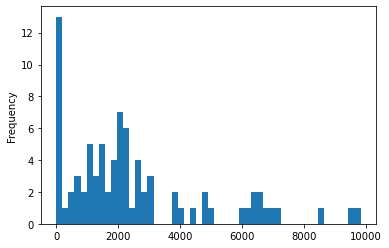

In [17]:
ship_counts['COUNTS'].plot(kind='hist',bins=50)

Посмотрим внимательнее на признаки, сразу замечаем присутствие значений "!ERR". Выясняем у бизнеса. Оказывается, из отчетной системы выгружаются значения !ERR если иерархия отсутствует.

In [18]:
df['Region'].value_counts()

South         44948
Volga         33893
Siberia       32200
East          25373
Ural          23755
North-West    23739
!ERR          20071
Moscow        17724
Name: Region, dtype: int64

Представим значения !ERR как NaN и посмотрим статистики по пропущенным значениям.

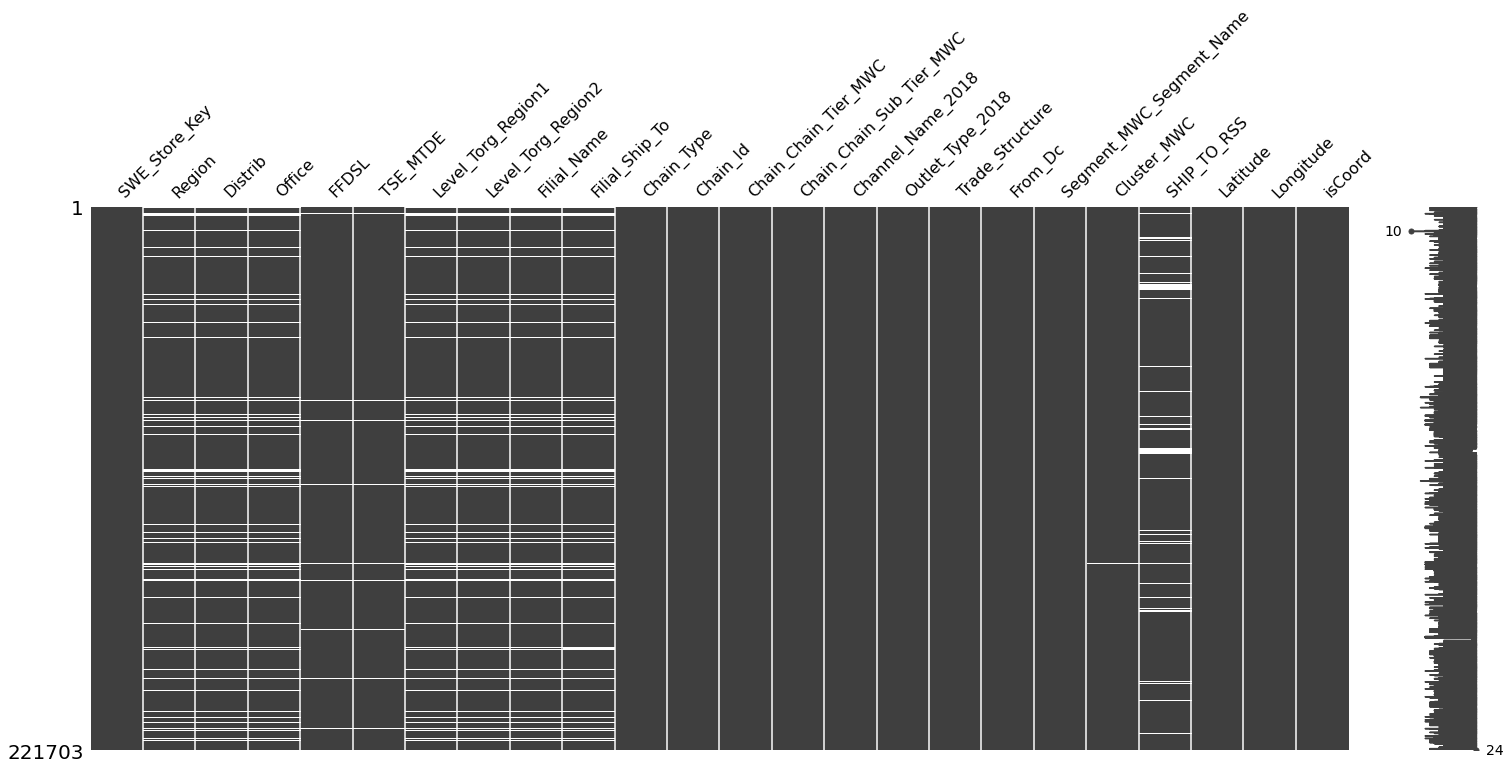

In [19]:
df.replace('!ERR', np.NaN, inplace=True)
msno.matrix(df)

Оценим пропуски количественно, для этого создадим таблицу некоторых статистик для всех признаков.

In [20]:
df_stats = pd.DataFrame(columns = ['column', 'values', 'num_unique', 'num_nan', 'pct_nan'])
tmp = pd.DataFrame()

for c in df.columns:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['num_unique'] = len(list(df[c].unique()))
    tmp['num_nan'] = df[c].isnull().sum()
    tmp['pct_nan'] = round(df[c].isnull().sum() / df.shape[0] * 100, 1)
    df_stats = df_stats.append(tmp)
    
df_stats[['column','values','num_unique','num_nan','pct_nan']]

,column,values,num_unique,num_nan,pct_nan
0,SWE_Store_Key,"[1000201031, 100050000000002, 100050000000031,...",221703,0,0.0
0,Region,"[Siberia, North-West, nan, Moscow, Ural, Volga...",8,20071,9.1
0,Distrib,"[ООО Гермес, ЗАО Денди, SF Мегаполис, nan, ООО...",62,20018,9.0
0,Office,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",168,20018,9.0
0,FFDSL,"[MWC FFDL Kuzbass (Vetrova Marina), MWC FFDL S...",39,4499,2.0
0,TSE_MTDE,"[MWC TSE Novokuznetsk (Sandler Kseniya), MWC T...",359,4499,2.0
0,Level_Torg_Region1,"[TL MWC: Север Кузбасса (Мокроусов Илья), TL: ...",521,20018,9.0
0,Level_Torg_Region2,[Агент МарсРигли-08 (Киселевск-2)(Погребных А....,2529,20018,9.0
0,Filial_Name,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",106,20019,9.0
0,Filial_Ship_To,"[10340352, 10407751, 10407053, nan, 10399270, ...",97,21163,9.5


Изучение предметной области говорит о том, что иерархия сотрудников компании (FFDSL, TSE_MTDE) задается отдельно от иерархии дистрибьюторов (куда попадают также торговые агенты Level_Torg_). Это подтверждает количество пропущенных значений (примерно 9% для иерархии дистрибьюторов и 2% для иерархии сотрудников).

Чтобы подтвердить это предположение, построем тепловую карту корреляции пропущенных значений. По ней видно, что наличие пропущенных значений в признаках иерархии дистрибьютора (Distrib, Office, Level_Torg_Region1, Level_Torg_Region1, Filial_Name, Filial_Ship_To) имеет прямую корреляцию (значение 1). Также коррелирует появление пропущенных значений для признаков иерархии сотрудников (FFDSL и TSE_MTDE). Корреляция между этими двумя группами признаков существует, но в незначительной степени.

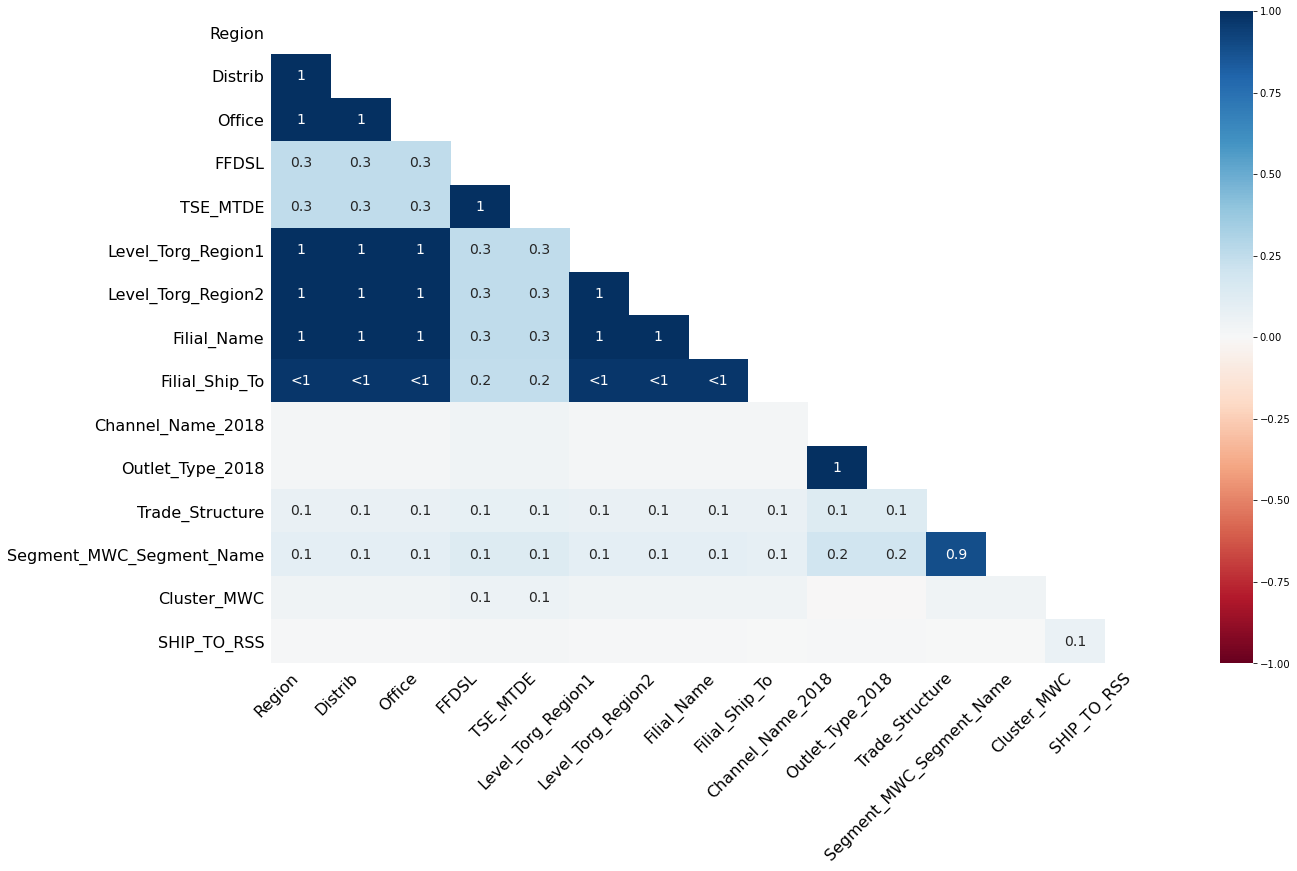

In [21]:
msno.heatmap(df)

Как видно из графика, пропущенные значения присутствуют для каждого региона. Больше всего пропусков для региона Сибирь в абсолютном и относительном размере.

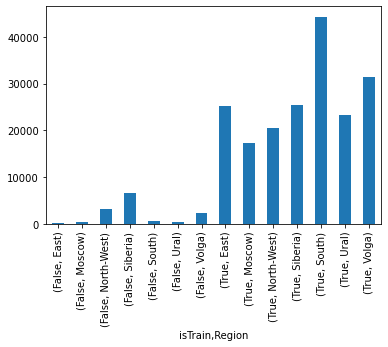

In [22]:
df['isTrain'] = ~ df['SHIP_TO_RSS'].isna()
df.groupby(['isTrain', 'Region']).SWE_Store_Key.count().plot(kind='bar')

### Сохраним текущий набор данных для дальнейших экспериментов

In [23]:
df['From_Dc'] = df['From_Dc'].astype(int)
df['Chain_Id'] = df['Chain_Id'].astype(str)
# Установить поле как индекс, тем самым исключив его из списка признаков
df.set_index('SWE_Store_Key',inplace=True)
df_init2 = df.copy()

## Моделирование

### Разделение на тренировочную и валидационную выборку

При подготовке данных был добавлен технический признак isTrain, который поможет отделить данные которые нужно предсказать, от данных для обучения (которые разделим на тренировочную и валидационную выборку в соотношении 70 на 30), с контролем стратификации по SHIP_TO_RSS, при которой обеспечивается попадание значений "y" в тренировочную и валидационную выборки.

Не забудем исключить такие SHIP_TO_RSS, которые содержат меньше  25 сэмплов.

In [24]:
ships = list(ship_counts['SHIP_TO_RSS'][ship_counts['COUNTS']<25].values)

target = ['SHIP_TO_RSS']
service = ['isTrain','isCoord']
features = [column for column in df.columns if column not in target and column not in service]
X = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships))][features]
y = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships))][target]
y['SHIP_TO_RSS'] = y['SHIP_TO_RSS'].astype(int)

cat_features = X.select_dtypes(include=['object']).columns  # Categorical
num_features = X.select_dtypes(exclude=['object']).columns  # Numeric

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Обучение

Для обучения модели используем ковейер данных (Pipeline) в котором выполним замену пропущенных значений, а также кодирование в One Hot. Конвейеры упрощают код, а также выполняют работу в разреженных матрицах. Разряженные матрицы важны когда имеется много категорийных данных, как в нашем случае.

In [25]:
def model_fit(X_train, y_train, classifier):
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    preprocessing = ColumnTransformer(
        [('cat', cat_pipe, cat_features),
         ('num', num_pipe, num_features)
        ])
    rf = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', classifier)
    ])
    rf.fit(X_train, y_train.values.ravel())
    return rf

clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
model = model_fit(X_train, y_train, clf)
y_pred = model.predict(X_valid)

### Выбор метрики

Для мультиклассовой классификации, в условиях несбалансированной выборки, допустимо использовать несколько различных метрик https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics. Для нашей задачи будем использовать метрику balanced_accuracy_score, которая определяется как средняя величина полноты (recall), полученная по каждому классу.

В случае, если классификатор работает одинаково хорошо для всех классов, то эта метрика работает как обычная точность, то есть отношение правильных предсказаний к общему количеству предсказаний. Если же обычная точность выше вероятности только потому, что классификатор использует несбалансированный набор тестов, тогда сбалансированная точность, в зависимости от ситуации, снизится до 1/n_classes (https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).

In [26]:
print('balanced accuracy score: {:.3f}'.format(balanced_accuracy_score(y_valid, y_pred)))

balanced accuracy score: 0.989


Как видно, сразу получено очень хорошее значение метрики. Попробуем убедиться, что этот результат действительно хорош, а также, возможно ли его улучшить?

### Как отсутствие иерархий влияет на результат?

Попробуем подтвердить предположение, что отсутствие иерархий влияет на количество ошибок. Для этого соберем набор данных с агрегированной информацией по каждому классу SHIP_TO_RSS.

In [27]:
ship_to_prediction_result_df = pd.DataFrame()

# Сколько всего записей в тестовом наборе данных
test_data = X.copy()
test_data['SHIP_TO_RSS'] = y['SHIP_TO_RSS']
test_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
ship_to_prediction_result_df['SHIP_TO_RSS'] = test_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
ship_to_prediction_result_df.columns = ['test_samples_counts']

In [28]:
# Подсчитаем сколько записей в тренировочном наборе
train_data = X_train.copy()
train_data['SHIP_TO_RSS'] = y_train['SHIP_TO_RSS']
train_data_df = train_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
train_data_df.columns = ['train_samples_counts']
ship_to_prediction_result_df.loc[train_data_df.index,'train_samples_counts'] = \
    train_data_df['train_samples_counts']

In [29]:
# Подсчитаем сколько записей в валидационном наборе
valid_data = X_valid.copy()
valid_data['SHIP_TO_RSS'] = y_valid['SHIP_TO_RSS']
valid_data_df = valid_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
valid_data_df.columns = ['valid_samples_counts']
ship_to_prediction_result_df.loc[valid_data_df.index,'valid_samples_counts'] = \
    valid_data_df['valid_samples_counts']

In [30]:
# Подсчитаем количество ошибочных предсказаний
y_compare = y_valid.copy()
y_compare['SHIP_TO_RSS_PRED'] = y_pred
y_wrong_predicted = y_compare[y_compare['SHIP_TO_RSS']!=y_compare['SHIP_TO_RSS_PRED']].copy()
y_wrong_predicted_df = y_wrong_predicted.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
y_wrong_predicted_df.columns = ['wrong_predicted_counts']
ship_to_prediction_result_df.loc[y_wrong_predicted_df.index,'wrong_predicted_counts'] = \
    y_wrong_predicted_df['wrong_predicted_counts']

In [31]:
# Ошибка в процентах от количества записей в проверочном наборе данных
ship_to_prediction_result_df['wrong_predicted_percentage'] = \
    ship_to_prediction_result_df['wrong_predicted_counts'] / \
    ship_to_prediction_result_df['valid_samples_counts'] * 100

In [32]:
# Посчитаем сколько всего записей с иерархиями дистрибьюторов и сотрудников
test_data['dist_hierarchy_exists'] = ~test_data['Region'].isna()
test_data['associates_hierarchy_exists'] = ~test_data['FFDSL'].isna()

dist_hierarchy_exists_df = test_data[test_data['dist_hierarchy_exists']==True]. \
    groupby(['SHIP_TO_RSS','dist_hierarchy_exists']).dist_hierarchy_exists.count().to_frame()
dist_hierarchy_exists_df.columns = ['dist_hierarchy_exists_counts']
dist_hierarchy_exists_df.reset_index(inplace=True)
dist_hierarchy_exists_df.set_index('SHIP_TO_RSS',inplace=True)
dist_hierarchy_exists_df.drop('dist_hierarchy_exists',axis=1,inplace=True)

associates_hierarchy_exists_df = test_data[test_data['associates_hierarchy_exists']==True]. \
    groupby(['SHIP_TO_RSS','associates_hierarchy_exists']).associates_hierarchy_exists.count().to_frame()
associates_hierarchy_exists_df.columns = ['associates_hierarchy_exists_counts']
associates_hierarchy_exists_df.reset_index(inplace=True)
associates_hierarchy_exists_df.set_index('SHIP_TO_RSS',inplace=True)
associates_hierarchy_exists_df.drop('associates_hierarchy_exists',axis=1,inplace=True)

ship_to_prediction_result_df.loc[dist_hierarchy_exists_df.index,'dist_hierarchy_exists_counts'] = \
    dist_hierarchy_exists_df['dist_hierarchy_exists_counts']
ship_to_prediction_result_df.loc[associates_hierarchy_exists_df.index,'associates_hierarchy_exists_counts'] = \
    associates_hierarchy_exists_df['associates_hierarchy_exists_counts']

ship_to_prediction_result_df['dist_hierarchy_exists_percentage'] = \
    ship_to_prediction_result_df['dist_hierarchy_exists_counts'] / \
    ship_to_prediction_result_df['test_samples_counts'] * 100

ship_to_prediction_result_df['associates_hierarchy_exists_percentage'] = \
    ship_to_prediction_result_df['associates_hierarchy_exists_counts'] / \
    ship_to_prediction_result_df['test_samples_counts'] * 100

fields_to_output = ['test_samples_counts','wrong_predicted_percentage',
                    'dist_hierarchy_exists_percentage','associates_hierarchy_exists_percentage']
ship_to_prediction_result_df.sort_values('wrong_predicted_percentage',ascending=False)[fields_to_output][:15]

,test_samples_counts,wrong_predicted_percentage,dist_hierarchy_exists_percentage,associates_hierarchy_exists_percentage
SHIP_TO_RSS,,,,
10441602,38,18.181818,52.631579,68.421053
10432783,1112,6.586826,96.762590,99.010791
10428588,8553,5.183164,91.815737,94.528236
10430024,6310,4.965663,88.399366,97.400951
10407810,6491,4.879301,63.842243,92.204591
10398269,2093,4.617834,92.881032,99.665552
10433225,1446,3.225806,99.031812,99.930844
10190426,470,2.836879,90.851064,99.787234
10407751,2263,2.356406,98.188246,96.111357


Построим графики с типом bar для первых 15-ти классов с наибольшей относительной ошибкой.

Убеждаемся, что не смотря на то, что для класса с максимальной ошибкой отсутствие иерархий ярко выражено, для последующих классов мы видим, что относительная ошибка уменьшается, а наличие иерархий не имеет патерна снижения. Таким образом, делаем вывод, что наличие иерархий не оказывает заметного влияния на ошибки.

C:\Programs\anaconda3\envs\Territory_App\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Programs\anaconda3\envs\Territory_App\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Programs\anaconda3\envs\Territory_App\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Programs\anaco

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DE0B7CD508>,
      dtype=object)

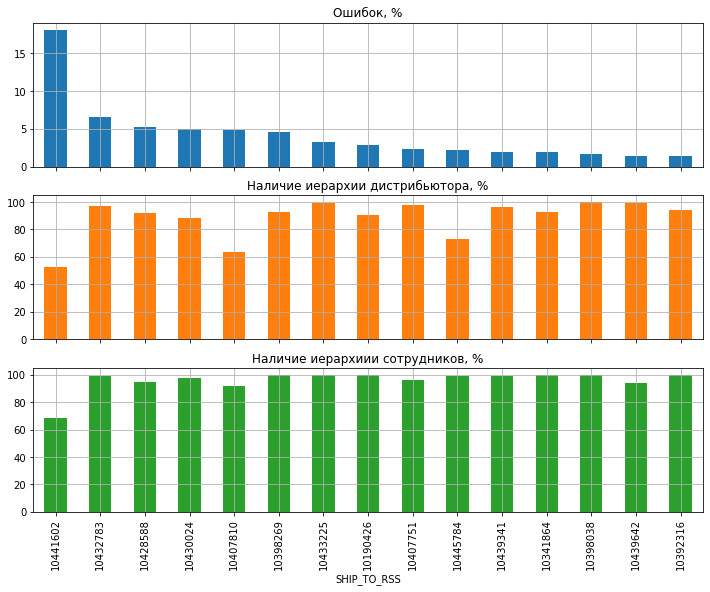

In [33]:
ship_to_prediction_result_df \
    .loc[:,['wrong_predicted_percentage','dist_hierarchy_exists_percentage',
            'associates_hierarchy_exists_percentage']] \
        .sort_values('wrong_predicted_percentage',ascending=False)[:15].plot(
            kind='bar',
            grid = True, 
            subplots = True, 
            title = ['Ошибок, %','Наличие иерархии дистрибьютора, %','Наличие иерархиии сотрудников, %'], 
            legend = False,
            figsize=(12,9))

### Эксперимент с исключением данных с пропущенными значениями

Поскольку пропущенные значения разных признаков имеют одинаковую специальную метку, в момент кодировки One Hot Encoding, это может отрицательно влиять на процесс обучения. Попробуем откинуть данные с пропущенными значениями, тем более, что из не больше 10% от общего количества

In [34]:
df = df_init2.copy()
df['SHIP_TO_RSS'].replace(np.NaN, 0, inplace=True)
df.dropna(axis=0, inplace=True)
df['SHIP_TO_RSS'].replace(0, np.NaN, inplace=True)

In [35]:
ships = list(ship_counts['SHIP_TO_RSS'][ship_counts['COUNTS']<25].values)

target = ['SHIP_TO_RSS']
service = ['isTrain','isCoord']
features = [column for column in df.columns if column not in target and column not in service]
X = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships))][features]
y = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships))][target]
y['SHIP_TO_RSS'] = y['SHIP_TO_RSS'].astype(int)

cat_features = X.select_dtypes(include=['object']).columns  # Categorical
num_features = X.select_dtypes(exclude=['object']).columns  # Numeric
    
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [36]:
clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
model = model_fit(X_train, y_train, clf)
y_pred = model.predict(X_valid)
print('balanced accuracy score: {:.3f}'.format(balanced_accuracy_score(y_valid, y_pred)))

balanced accuracy score: 0.993


Мы получили ещё больший score!

### Важность признаков

Воспользуемся специальным приемом, чтобы получить из конвейера информацию об исходных признаках, о новых One-Hot признаках, а также о суммарной важности каждого One-Hot признака в финальное предсказание.

In [37]:
# Получить объект OneHotEncoder
ohe = (model.named_steps['preprocess']
       .named_transformers_['cat']
       .named_steps['onehot'])

# Получить названия новых One Hot признаков
cat_ohe_feature_names = ohe.get_feature_names(input_features=cat_features)

# К One Hot признакам присоединить числовые признаки, которые участвовали в обучении модели
feature_names = np.append(cat_ohe_feature_names, num_features)

# Вместо уникальных названий One Hot признаков получить массив исходных названий признаков той же длины
features_raw = []
for fname, fval  in zip(cat_features,ohe.categories_):
    features_raw = np.append(features_raw, [fname] * len(fval))
features_raw = np.append(features_raw, num_features)

# Получить объект с классификатором
rfc = model.named_steps['classifier']

# Создать DataFrame с тремя столбцами:
# исходный признак, соответствующий One Hot признак, важность признака из классификатора
fimp_pd = pd.DataFrame(
        {"Feature":features_raw,
         "FeatureName":feature_names,
         "Importance":rfc.feature_importances_}
    ).sort_values(["Importance"], ascending=False)

Интересный факт, что именно информация о иерархии доистрибьютора и иерархии сотрудников оказывают наибольшее влияение в итоговый результат предсказания. Координаты точки идут сразу после этих признаков.

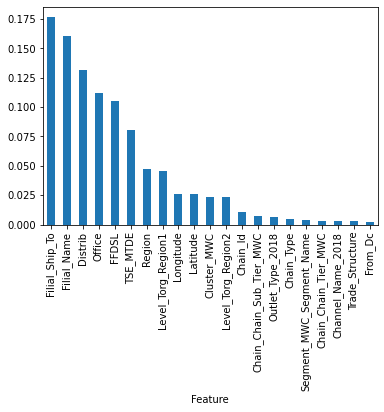

In [38]:
fimp_pd.groupby('Feature').Importance.sum().sort_values(ascending=False).plot(kind='bar')

## Выводы

В процессе выполнения работы входные данные были проанализированы и очищены. Для ответа на некоторые вопросы, привлекался человек из бизнеса со знанием предметной области. Выдвинуто предположение о важности координат для точек, поэтому был разработан алгоритм восстановления координат для 10% точек. Кроме того было обнаружено, что для 9% точек отсутствует иерархия дистрибьюторов, а для 2% точек нет иерархии сотрудников. Возникло опасение, что это повлияет на точность предсказания.

Полученный набор данных является несбалансированным, поэтому для оценки модели была использована метрика balanced accuracy score, которая учитывает несбалансированность классов. В процессе моделирования было достигнуто значение метрики больше 0.97, при этом одинаково хорошая оценка достигалась при использовании разных классификаторов, например, Logistic Regression. Было решено остановиться на алгоритме  Random Forest Classifier, который показал максимальное значение.

Анализ важности признаков показал, что вклад признаков, которые относятся к иерархиям дистрибьюторов и сотрудников, выше, чем координат торговых точек. При этом не подтверждено существенное влияние отсутствия иерархий  на правильность ответа. С другой стороны мы убедились, что малое значение (до 40) записей в классе, приводит к низкой точности предсказания. Из-за этого последовала рекомендация предупреждать пользователя о наличии таких классов, но не предстказывать их.   